# Setup

In [1]:
import gym
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorrt
import tensorflow as tf
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio

In [2]:
len(gym.envs.registry)

996

# Making the Gym environment

In [3]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [4]:
obs, info = env.reset(seed=42)
# horizontal position (0.0 means center)
# velocity (positive means right)
# angle of pole (0.0 means vertical)
# angular velocity (positive means clockwise) 
print(obs)
# Environment-specific. Here it is empty.
print(info)

[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]
{}


In [5]:
img = env.render()

(400, 600, 3)


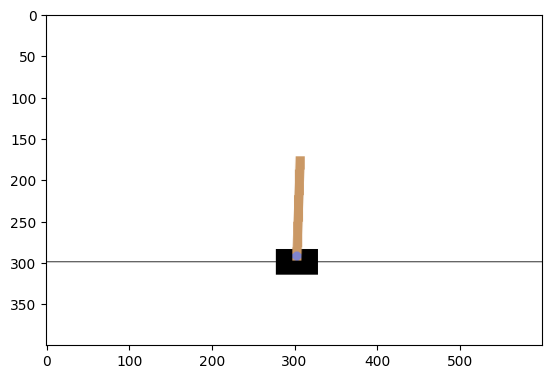

In [6]:
print(img.shape)
plt.imshow(img)
display()

In [9]:
print(env.action_space)
env.action_space.n

Discrete(2)


2

In [10]:
action = 1 # accelerate right
obs, reward, done, truncated, info = env.step(action)
print(obs)
print(reward)
print(done)
print(truncated)
print(info)

[ 0.02727336  0.18847767  0.03625453 -0.26141977]
1.0
False
False
{}


In [11]:
img = env.render()

(400, 600, 3)


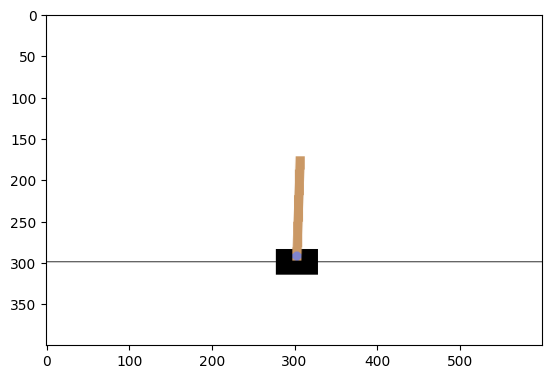

In [12]:
print(img.shape)
plt.imshow(img)
display()

# Building a hard-coded policy

In [13]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_reward = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_reward += reward
        if done or truncated:
            break

    totals.append(episode_reward)

np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

# Building a neural network policy

## The network

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

## The inner working

In [15]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)  # True => right, False => left
        y_target = tf.constant([[1.]]) - tf.cast(action, dtype=tf.float32)
        # The loss function is used here to increase the probability of the action that was just taken.
        # If the the model predicted 0.2 (20% chance of going left) and the randomized action ended up 
        # with us going right, then int(action)=1 and y_target=0 (i.e. "0% chance of going left"), so we 
        # compute the loss between 0.2 and 0 so that next time the model is more confident in predicting
        # a number closer to 0.
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor) 
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [16]:
print(discount_rewards([10, 0, -50], discount_factor=0.8))
print(discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor=0.8))

[-22 -40 -50]
[array([-0.28435071, -0.86597718, -1.18910299]), array([1.26665318, 1.0727777 ])]


## The hyperparams

In [17]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

## The training loop

In [30]:
def train_model(model, n_iterations, n_episodes_per_update, n_max_steps, discount_factor):
    optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
    loss_fn = tf.keras.losses.binary_crossentropy
    for iteration in range(n_iterations):
        all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
        all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
        all_mean_grads = []
        for var_index in range(len(model.trainable_variables)):
            # For each trainable variable, compute the weighted mean of its gradients over all episodes and all steps,
            # weighted by the final_reward. Initially, the gradients per variable reflect a step towards the action
            # actually taken. But as we introduce rewards, this can change: negative rewards will actually push 
            # it to the opposite direction of the gradient.
            mean_grads = tf.reduce_mean(
                [
                    final_reward * all_grads[episode_index][step][var_index]
                    for episode_index, final_rewards in enumerate(all_final_rewards)
                        for step, final_reward in enumerate(final_rewards)
                ], axis=0)
            all_mean_grads.append(mean_grads)
        optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))
        print('.', end='')

def train_or_load_model(model, model_folder, **kwargs):
    if Path(model_folder).exists():
        return tf.keras.models.load_model(model_folder)
    else:
        train_model(model=model, **kwargs)
        model.save(model_folder, save_format='tf')
        return model

In [32]:
model = train_or_load_model(
    model, 
    'data/01-policy/01',
    n_iterations=n_iterations, 
    n_episodes_per_update=n_episodes_per_update, 
    n_max_steps=n_max_steps, 
    discount_factor=discount_factor, 
)

In [33]:
for x in model.trainable_variables:
    print(x.shape)

model.trainable_variables == model.trainable_weights

print(model.trainable_weights[0])

(4, 5)
(5,)
(5, 1)
(1,)
<tf.Variable 'dense/kernel:0' shape=(4, 5) dtype=float32, numpy=
array([[ 4.9890053e-01,  4.1784239e-01, -1.3949366e-02,  5.6299765e-02,
        -6.8623363e-04],
       [-6.7938656e-01,  8.4538913e-01,  1.2838671e-01, -2.2695495e-01,
         1.3203785e-01],
       [-1.2676984e+00, -4.9135035e-01,  1.6869855e+00,  7.1497774e-01,
        -5.8706723e-02],
       [-1.4064280e+00, -2.3572481e-01,  6.0852188e-01,  1.3012432e+00,
         4.0517163e-01]], dtype=float32)>


## Playing the game

In [34]:
def play_game(model, env, max_steps):
    obs, info = env.reset()
    frames = [env.render()]
    for step in range(max_steps):
        left_proba = model(obs[np.newaxis])
        action = int(tf.random.uniform([1, 1]) > left_proba)
        obs, reward, done, truncated, info = env.step(action)
        frames.append(env.render())
        if done or truncated:
            break
    return frames

In [35]:
def create_gif(file_path, model, env, n_max_steps, override=False):
    if not override and Path(file_path).exists():
        return False
    frames = play_game(model, env, n_max_steps)
    imageio.mimsave(file_path, frames, format='GIF', duration=20)
    return True

In [36]:
create_gif('data/cart.gif', model, env, n_max_steps)

False

## Bad model :)

In [38]:
bad_model = tf.keras.models.clone_model(model)

bad_model = train_or_load_model(
    bad_model, 
    'data/02-policy-bad/01',
    n_iterations=10, 
    n_episodes_per_update=n_episodes_per_update, 
    n_max_steps=n_max_steps, 
    discount_factor=discount_factor, 
)

In [41]:
create_gif('data/bad_cart.gif', bad_model, env, n_max_steps)

False

# Markov Decision Processes

In [42]:
# This reflects the graph in figure 18-8
# shape = (s, a, s')
transition_probabilities = [
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None,            [0.0, 0.0, 1.0]],
    [None,            [0.8, 0.1, 0.1], None],
]

# shape = (s, a, s')
rewards = [
    [[10, 0, 0], [0, 0, 0],  [0, 0, 0]],
    [[0, 0, 0],  [0, 0, 0],  [0, 0, -50]],
    [[0, 0, 0],  [40, 0, 0], [0, 0, 0]],
]

possible_actions = [[0, 1, 2], [0, 2], [1]]

## Q-value iteration aglorithm

### When we know the transition probabilities and rewards

In [43]:
Q_values = np.full(shape=(3, 3), fill_value=-np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0


# Discount factor
gamma = 0.90

for iterations in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                transition_probabilities[s][a][sp] 
                * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                for sp in range(3) 
            ])

print(Q_values)

[[18.91891892 17.02702702 13.62162162]
 [ 0.                -inf -4.87971488]
 [       -inf 50.13365013        -inf]]


## Q-Learning

### When we don't know the transition probabilities or rewards

In [44]:
# Initialize Q-values with zeroes
Q_values = np.full(shape=(3, 3), fill_value=-np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0

In [45]:
# Fully random
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

# Get the next state and immediate reward based on action taken
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

alpha0 = 0.05  # initial learning rate
decay = 0.005  # learning rate decay
gamma = 0.90   # discount factor
state = 0      # initial state

for iteration in range(10_000):
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    # Greedy policy at next step
    next_value = Q_values[next_state].max()
    # This decay approach is similar to power-scheduling
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

print(Q_values)

[[18.3441667  15.94753638 13.03186405]
 [ 0.                -inf -9.44323714]
 [       -inf 48.30531401        -inf]]


## Deep Q-Learning

### For the cart pole problem

In [47]:
# DQN example for the cart pole problem
from collections import deque

# env.observation_space.shape
input_shape = [4]
# env.action_space.n
n_outputs = 2

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='elu', input_shape=input_shape),
    tf.keras.layers.Dense(32, activation='elu'),
    tf.keras.layers.Dense(n_outputs)
])

def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis], verbose=False)[0]
        # Optimal action according to the DQN
        return Q_values.argmax()
    

replay_buffer = deque(maxlen=2000)

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    # Similar to `batch = replay_buffer[indices]` had replay_buffer been an ndarray
    batch = [replay_buffer[index] for index in indices]
    # Similar to batch.T had it been an ndarray. Returns:
    # [states, actions, rewards, next_states, dones, truncateds]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append([state, action, reward, next_state, done, truncated])
    return next_state, reward, done, truncated, info    

In [48]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    # (a) Take a batch of experiences from the replay buffer. This is of shape (6, 32)
    experiences = sample_experiences(batch_size)
    # Each of these is of shape (32,)
    states, actions, rewards, next_states, dones, truncateds = experiences
    # (b) Calculate the targets for the DQN
    # Step 1 - predict the next Qᶿ(s', a'). 
    # Return shape: (32, 2) as there are 2 outputs to the DQN.
    # The values mean the approximate reward for each action in the next step s'.
    next_Q_values = model.predict(next_states, verbose=False)
    # Step 2 - Find Maxₐ.Qᶿ(s', a'), i.e. the max reward that can be achieved in 
    # step s'. This is the assumption the agent is acting optimally.
    # Return shape: (32, 1)
    max_next_Q_values = next_Q_values.max(axis=1)
    # Step 3 - build a (32, 1) binary mask where 1 indicates the episode is not over
    # and 0 otherwise, ensuring no future rewards are considered for terminal states.
    runs = 1.0 - (dones | truncateds)  
    # Step 4 - Calculate the target value for the DQN, of shape (32, 1)
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    # (c) Calculate a mask used to extract the reward of the action actually taken
    # This is a (32, 2) matrix, each containing a one-hot encoded vector representing
    # the action that the agent took.
    mask = tf.one_hot(actions, n_outputs)
    # (d) run one forward pass
    with tf.GradientTape() as tape:
        # Recall that model.predict() does not contribute to recording operations in
        # GradientTape context, which is why model() is used. 
        # Return value is of shape (32, 2)
        all_Q_values = model(states)
        # Calculate the estimated reward of the action actually taken, including discounted
        # future rewards. Returns shape (32, 1)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        # Returns a scalar of the mean loss across samples 
        # (each sample's loss is MSE vs. target Q values).
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    # (e) Run one backprop pass 
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [50]:
model_folder = Path() / 'data' / '03-dqn'
if model_folder.exists():
    model = tf.keras.models.load_model(model_folder)
else:
    for episode in range(600):
        obs, info = env.reset()
        for step in range(200):
            # For the ε-greedy policy, decay ε linearly from 1 to 0.01 within the first 500 episodes
            epsilon = max(1 - episode / 500, 0.01)
            obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
            if done or truncated:
                break

        # Give the replay buffer some time to fill up
        if episode > 50:
            training_step(batch_size)

    model.save(model_folder)

### Playing the game

In [61]:
def play_dqn_game(model, env, max_steps):
    obs, info = env.reset()
    frames = [env.render()]
    for step in range(max_steps):
        actions = model.predict(obs[np.newaxis], verbose=False)[0]
        action = actions.argmax()
        obs, reward, done, truncated, info = env.step(action)
        frames.append(env.render())
        if done or truncated:
            break
    return frames

def create_dqn_gif(file_path, model, env, n_max_steps, override=False):
    if not override and Path(file_path).exists():
        return False
    frames = play_dqn_game(model, env, n_max_steps)
    print(len(frames))
    imageio.mimsave(file_path, frames, format='GIF', duration=20)
    return True


In [60]:
create_dqn_gif('data/cart-dqn.gif', model, env, n_max_steps)

False

## Double DQN

In [69]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='elu', input_shape=input_shape),
    tf.keras.layers.Dense(32, activation='elu'),
    tf.keras.layers.Dense(n_outputs)
])

target = tf.keras.models.clone_model(model)  # clone the model's architecture
target.set_weights(model.get_weights())  # copy the weights

In [70]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    # Instead of target.predict() like in the Fixed Q-value targets approach.
    # This returns (32, 2) of indices of the best actions the online model predicts
    # - not the target model's Q-values like before...
    next_Q_values = model.predict(next_states, verbose=False)
    # ...we then use these indices to fetch the target model's Q-values for each action,
    # and use them as the online model's targets as usual
    best_next_actions = next_Q_values.argmax(axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states, verbose=False) * next_mask).sum(axis=1)
    # The rest is the same...
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [71]:
model_folder = Path() / 'data' / '04-double-dqn'
if model_folder.exists():
    model = tf.keras.models.load_model(model_folder)
else:
    for episode in range(600):
        obs, info = env.reset()
        for step in range(200):
            # For the ε-greedy policy, decay ε linearly from 1 to 0.01 within the first 500 episodes
            epsilon = max(1 - episode / 500, 0.01)
            obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
            if done or truncated:
                break

        # Give the replay buffer some time to fill up
        if episode > 50:
            training_step(batch_size)

        if episode % 50 == 0:
            target.set_weights(model.get_weights())    

    model.save(model_folder)

In [72]:
create_dqn_gif('data/cart-double-dqn.gif', model, env, n_max_steps)

False

## Dual DQN (DDQN)

In [74]:
input_states = tf.keras.layers.Input(shape=[4])
hidden1 = tf.keras.layers.Dense(32, activation='elu')(input_states)
hidden2 = tf.keras.layers.Dense(32, activation='elu')(hidden1)
# V(s)
state_values = tf.keras.layers.Dense(1)(hidden2)
# A(s, a) before standardizing
raw_advantages = tf.keras.layers.Dense(n_outputs)(hidden2)
# A(s, a) after standardizing, ensuring A(s, a*) is 0 and all the rest are negative
advantages = raw_advantages - tf.reduce_max(raw_advantages, axis=1, keepdims=True)
# Q(s, a) = V(s) + A(s, a)
Q_values = state_values + advantages
model = tf.keras.Model(inputs=[input_states], outputs=[Q_values])

target = tf.keras.models.clone_model(model)  # clone the model's architecture
target.set_weights(model.get_weights())  # copy the weights

In [75]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=False)
    best_next_actions = next_Q_values.argmax(axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states, verbose=False) * next_mask).sum(axis=1)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [76]:
model_folder = Path() / 'data' / '05-ddqn'
if model_folder.exists():
    model = tf.keras.models.load_model(model_folder)
else:
    for episode in range(600):
        obs, info = env.reset()
        for step in range(200):
            # For the ε-greedy policy, decay ε linearly from 1 to 0.01 within the first 500 episodes
            epsilon = max(1 - episode / 500, 0.01)
            obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
            if done or truncated:
                break
        # Give the replay buffer some time to fill up
        if episode > 50:
            training_step(batch_size)

        if episode % 50 == 0:
            target.set_weights(model.get_weights())    

    model.save(model_folder)

INFO:tensorflow:Assets written to: data/05-ddqn/assets


INFO:tensorflow:Assets written to: data/05-ddqn/assets


In [77]:
create_dqn_gif('data/cart-ddqn.gif', model, env, n_max_steps)

201


True